# An example-based introduction to pymc3-kalman

In this notebook, we will make a Bayesian estimate of the parameters governing a one-dimensional random walk, including observation noise. It is based on [this post](http://www.chadfulton.com/topics/state_space_mh.html). Here, we use a generic Kalman filter representation.

The equations governing the system are the following:

\begin{align*}
y_t & = \mu_t + \varepsilon_t, \qquad \varepsilon_t \sim N(0, \sigma_\varepsilon^2) \\
\mu_{t+1} & = \mu_t + \eta_t, \qquad \eta_t \sim N(0, \sigma_\eta^2) \\
\end{align*}

Let's create a deterministic "random" configuration:

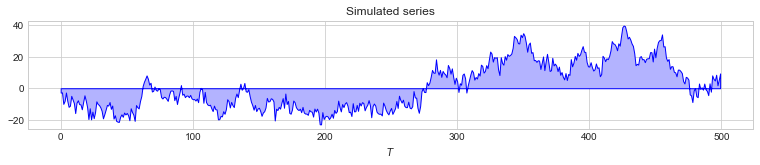

In [1]:
import numpy              as np
import matplotlib.pyplot  as plt
import seaborn            as sns
sns.set_style("whitegrid")

%matplotlib inline

# True values
T = 500                 # Time steps
sigma2_eps0 = 3         # Variance of the observation noise
sigma2_eta0 = 10        # Variance in the update of the mean

# Simulate data
np.random.seed(12345)
eps = np.random.normal(scale=sigma2_eps0**0.5, size=T)
eta = np.random.normal(scale=sigma2_eta0**0.5, size=T)
mu = np.cumsum(eta)
y = mu + eps

# Plot the time series
fig, ax = plt.subplots(figsize=(13,2))
ax.fill_between(np.arange(T), 0, y, facecolor=(0.7,0.7,1), edgecolor=(0,0,1))
ax.set(xlabel='$T$', title='Simulated series');

As a reminder, the equations describing a system in State Space Form are the _measurement equation_

$$
\boldsymbol y_t = \boldsymbol Z_t \boldsymbol\alpha_t + \boldsymbol d_t
                + \boldsymbol\varepsilon_t ,\qquad t=1,\ldots,T
\qquad\qquad \boldsymbol\varepsilon_t \sim \mathcal{N}(0, \boldsymbol H_t)\ ,
$$

and a _transition equation_:

$$
\boldsymbol\alpha_t = \boldsymbol T_t \boldsymbol\alpha_{t-1} + \boldsymbol c_t
                    + \boldsymbol R_t \boldsymbol \eta_t ,\qquad t=1,\ldots,T
\qquad\qquad \boldsymbol\eta_t \sim \mathcal{N}(0, \boldsymbol Q_t)\ ,
$$                  

where $\boldsymbol y_t$ is the observable vector, of length $n$, and $\boldsymbol\alpha_t$ is the state vector, of length $m$.

Our system can be readily written in these terms, by setting $\boldsymbol\alpha_t = \mu_t$. Then,

\begin{align*}
\boldsymbol Z_t &= \left(\begin{array}{c} 1 \end{array}\right) &
\boldsymbol d_t &= 0 &
\boldsymbol H_t &= \left(\begin{array}{c} \sigma_\varepsilon^2 \end{array}\right)
\end{align*}

\begin{align*}
\boldsymbol T_t &= \left(\begin{array}{c} 1 \end{array}\right) &
\boldsymbol c_t &= 0 &
\boldsymbol R_t &= \left(\begin{array}{c} 1 \end{array}\right) &
\boldsymbol Q_t &= \left(\begin{array}{c} \sigma_\eta^2 \end{array}\right)
\end{align*}

Using the kalman package, it is straightforward to create a probabilistic model. For that, we must choose priors for the 2 parameters, $\sigma_\varepsilon^2$ and $\sigma_\eta^2 $, and an initial guess for $\boldsymbol y_0$. As both the observation vector and the state space are of size 1, it is possible to define all the matrices as scalar, reducing the computational complexity:

In [2]:
import kalman
import pymc3
from pymc3 import Model, HalfCauchy

with Model() as model:
    
    ɛ_σ2 = HalfCauchy(name='ɛ_σ2', beta=1e6)
    η_σ2 = HalfCauchy(name='η_σ2', beta=1e6)
    
    Z = np.array(1.)
    d = np.array(0.)
    H = ɛ_σ2
    
    T = np.array(1.)
    c = np.array(0.)
    R = np.array(1.)
    Q = η_σ2
    
    a0 = np.array(0.)
    P0 = np.array(1e6)
    
    ts = kalman.KalmanFilter('ts', Z, d, H, T, c, R, Q, a0, P0, observed=y)

First, we will look at the maximum a posteriori point (MAP):

In [3]:
import re

with model:
    MAP = pymc3.find_MAP()

# We need to undo the log transform
{re.sub('_log__', '', k): np.exp(v) for k,v in MAP.items()}

Optimization terminated successfully.
         Current function value: 1392.123438
         Iterations: 9
         Function evaluations: 18
         Gradient evaluations: 18


{'ɛ_σ2': 4.0637910451086716, 'η_σ2': 7.1772934930815726}

The result seems a bit off with respect to the known true values. Let's sample the posterior to obtain a distribution of possible values for these parameters:

Auto-assigning NUTS sampler...
Initializing NUTS using ADVI...
Average Loss = 3,825.8:   2%|▏         | 4897/200000 [01:58<1:15:32, 43.05it/s]
Convergence archived at 4900
Interrupted at 4,900 [2%]: Average Loss = 3,978.2
100%|██████████| 1000/1000 [04:18<00:00,  4.87it/s]


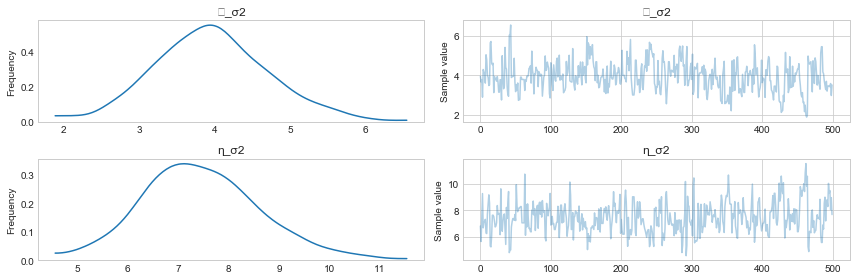

In [4]:
with model:
    trace = pymc3.sample()

pymc3.traceplot(trace);

As a final remark, note that a simple scatter plot of the samples shows that the chosen parametrization is probably not optimal, with a high correlation:

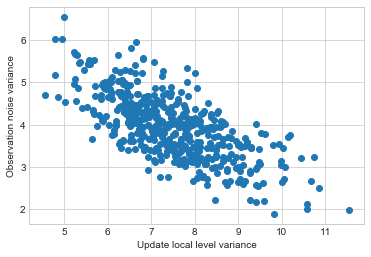

In [5]:
plt.scatter(trace['η_σ2'], trace['ɛ_σ2'])
plt.setp(plt.gca(), 'xlabel', 'Update local level variance',
                    'ylabel', 'Observation noise variance');